# RNA-seq analysis with DESeq2
## Largely from Stephen Turner, @genetics_blog


Using data from GSE37704, with processed data available on Figshare DOI: 10.6084/m9.figshare.1601975.
This dataset has six samples from GSE37704, where expression was quantified by either:
* Mapping to to GRCh38 using STAR then counting reads mapped to genes with featureCounts under the union-intersection model, or
* Alignment-free quantification using Sailfish, summarized at the gene level using the GRCh38 GTFile. Both datasets are restricted to protein-coding genes only.

We're using the Sailfish data.

This example comes from [a gist template for DESeq analyis](https://gist.github.com/stephenturner/f60c1934405c127f09a6) and a [blog post](
http://www.gettinggeneticsdone.com/2015/12/tutorial-rna-seq-differential.html), both by Stephen Turner.

First we pull in the data from a remote copy:

# set up the countdata, and metadata

In [1]:
countdata <- read.csv("rsem.gene.summary.count.txt", header=T, sep="\t",row.names=1)

In [2]:
countdata=countdata[,order(colnames(countdata),decreasing = F)]

In [3]:
colnames(countdata)=gsub(".rsem","",colnames(countdata))

In [4]:
nrow(countdata)

[1] 1126

In [5]:
countdata=countdata[order(rowMeans(countdata),decreasing=TRUE),]

In [6]:
countdata=countdata[rowMeans(countdata)>0,]

In [7]:
rowMeans(countdata)

0610005C13Rik         Trap1         Pam16         Nat15        Dnaja3 
 3.598455e+05  9.424783e+04  8.583883e+04  7.718383e+04  6.155700e+04 
        Hmox2         Fgf21 5730403B10Rik         Mgrn1      Nudt16l1 
 5.176250e+04  4.294567e+04  3.658483e+04  3.262400e+04  2.280333e+04 
        Bcat2       Fam100a      AK208554         Coro7         Anks3 
 2.126267e+04  2.034083e+04  1.740500e+04  8.056167e+03  7.537167e+03 
       Nmral1        Cluap1        Zfp263         Adcy9      AK210685 
 7.461500e+03  5.623500e+03  5.200833e+03  5.095833e+03  4.980667e+03 
4930562C15Rik        Rasip1          Vasn         Tfap4        Crebbp 
 4.452333e+03  3.535833e+03  3.474167e+03  2.784500e+03  2.700000e+03 
       Zfp597      AK180712          Slx4        Dnase1           Srl 
 2.159333e+03  1.487833e+03  1.440167e+03  1.158500e+03  1.013333e+03 
      Plekha4       Gm16861        Zfp174        Gm5766 1700037C18Rik 
 8.853333e+02  8.343333e+02  6.625000e+02  6.568333e+02  6.563333e+02 
        Glis2      AK163292          Mefv      AK153988          Fut1 
 6.505000e+02  5.558333e+02  5.085000e+02  4.563333e+02  4.478333e+02 
     AK049852      AK154225         Nlrc3        Mamstr        Izumo1 
 2.738333e+02  2.511667e+02  1.958333e+02  1.741667e+02  1.251667e+02 
     Hsd17b14          Fut2          Sec1        Sept12           Pol 
 4.000000e+01  3.583333e+01  1.166667e+01  9.333333e+00  5.333333e+00

In [8]:
nrow(countdata)

[1] 50

In [9]:
head(countdata)

,ctrl1,ctrl2,ctrl3,expr1,expr2,expr3
,<int>,<int>,<int>,<int>,<int>,<int>
0610005C13Rik,311877,328432,322185,411990,397999,386590
Trap1,125773,100147,118613,72614,69815,78525
Pam16,74294,90728,66435,86174,108912,88490
Nat15,85960,81575,91144,66019,66132,72273
Dnaja3,78796,76366,70435,47579,46635,49531
Hmox2,54943,58944,55382,48928,43644,48734


In [10]:
meta=data.frame(cbind(c("ctrl1","ctrl2","ctrl3","expr1","expr2","expr3"),c("ctrl","ctrl","ctrl","expr","expr","expr")))
colnames(meta)=c("id","condition")

In [11]:
rownames(meta)=meta$id

In [12]:
#meta=data.frame(meta[,-1])

In [13]:
meta

,id,condition
,<chr>,<chr>
ctrl1,ctrl1,ctrl
ctrl2,ctrl2,ctrl
ctrl3,ctrl3,ctrl
expr1,expr1,expr
expr2,expr2,expr
expr3,expr3,expr


In [14]:
head(countdata)

,ctrl1,ctrl2,ctrl3,expr1,expr2,expr3
,<int>,<int>,<int>,<int>,<int>,<int>
0610005C13Rik,311877,328432,322185,411990,397999,386590
Trap1,125773,100147,118613,72614,69815,78525
Pam16,74294,90728,66435,86174,108912,88490
Nat15,85960,81575,91144,66019,66132,72273
Dnaja3,78796,76366,70435,47579,46635,49531
Hmox2,54943,58944,55382,48928,43644,48734


# feed the data to DESeq2

In [15]:
coldata <- meta

In [16]:
# Convert to matrix
countdata <- as.matrix(countdata)
head(countdata)

,ctrl1,ctrl2,ctrl3,expr1,expr2,expr3
0610005C13Rik,311877,328432,322185,411990,397999,386590
Trap1,125773,100147,118613,72614,69815,78525
Pam16,74294,90728,66435,86174,108912,88490
Nat15,85960,81575,91144,66019,66132,72273
Dnaja3,78796,76366,70435,47579,46635,49531
Hmox2,54943,58944,55382,48928,43644,48734


And we start the bioconductor DESeq2 analysis worfklow, first by initializing the DESeqDataSeet from the matrix we've created above:

In [17]:
suppressPackageStartupMessages(library(DESeq2))
dds <- DESeqDataSetFromMatrix(countData=countdata, colData=coldata, design=~condition)
dds

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 50 6 
metadata(1): version
assays(1): counts
rownames(50): 0610005C13Rik Trap1 ... Sept12 Pol
rowData names(0):
colnames(6): ctrl1 ctrl2 ... expr2 expr3
colData names(2): id condition

And now running the DESeq Pipeline:

In [18]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Quality Control Plots

We next perform some basic QC plots to examine the data behvaiour, first by looking at dispersions to ensure they behave smoothly and broadly decrease with counts:

In [19]:
#?plotDispEsts

ERROR: Error in if (legend) {: argument is not interpretable as logical


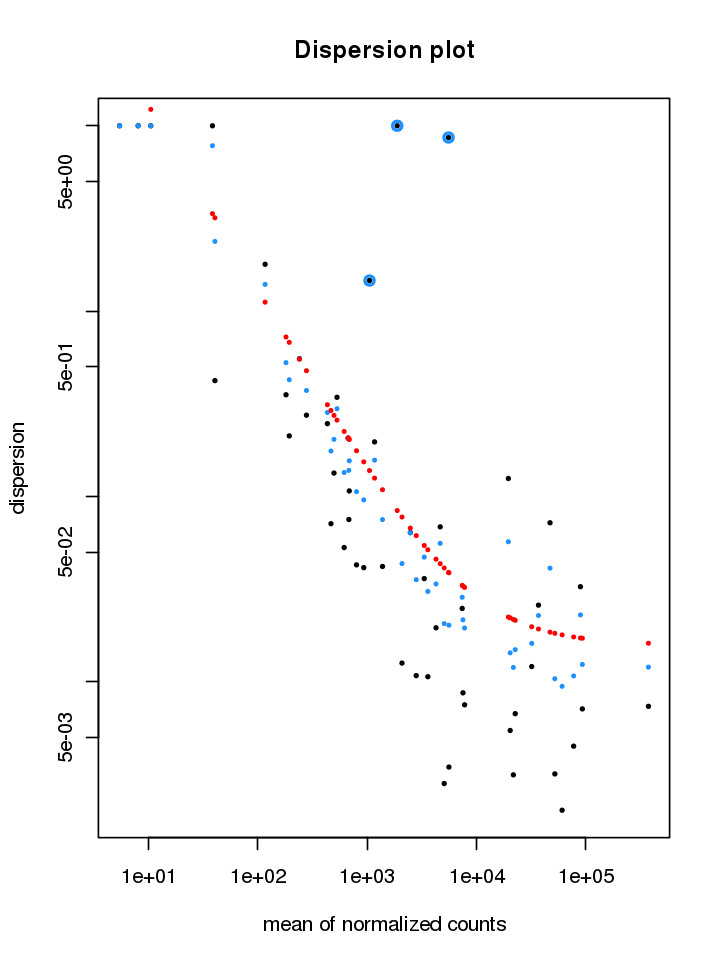

In [20]:
options(repr.plot.height=8, repr.plot.width=6)
plotDispEsts(dds, main="Dispersion plot",legend="bottomleft")

In general we're most interested in logs of the counts; DESeq has a regularlized log transform built in:

In [21]:
# Regularized log transformation for clustering/heatmaps, etc
rld <- rlogTransformation(dds)
head(assay(rld))

,ctrl1,ctrl2,ctrl3,expr1,expr2,expr3
0610005C13Rik,18.07000,18.16247,18.19165,18.84384,18.86894,18.61452
Trap1,16.65894,16.41035,16.66992,16.42007,16.43908,16.36595
Pam16,16.00014,16.27262,15.94669,16.61264,16.96866,16.49472
Nat15,16.15408,16.12006,16.30812,16.26384,16.33303,16.22450
Dnaja3,15.99365,15.98520,15.93920,15.80985,15.85233,15.70966
Hmox2,15.52009,15.63526,15.61193,15.81001,15.73753,15.65541


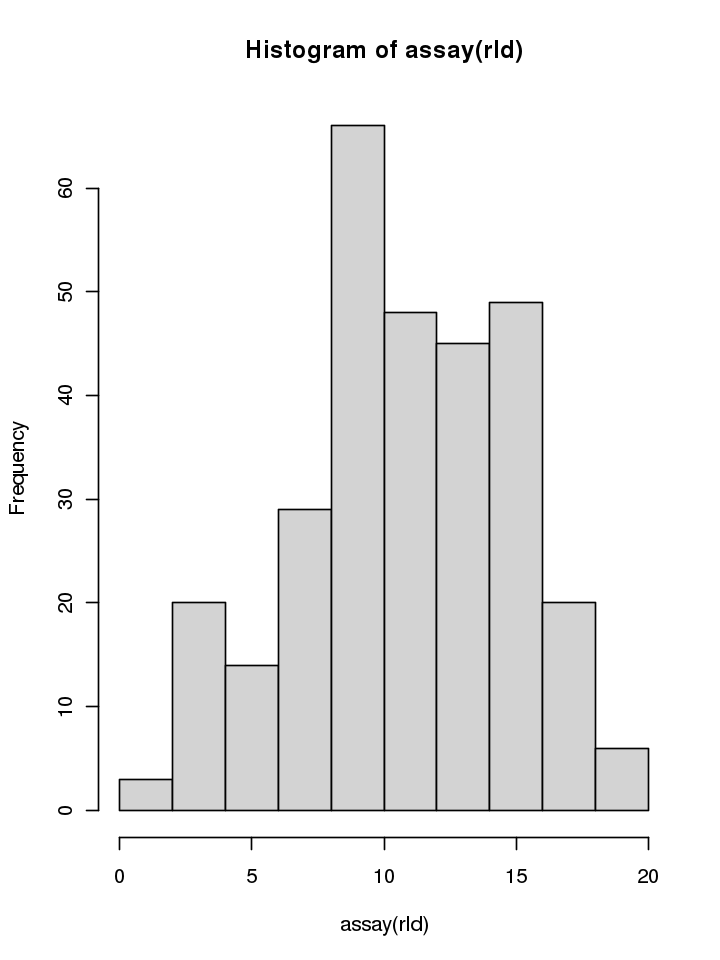

In [22]:
hist(assay(rld))

Now we'll make sure sure the samples cluster together by condition, first by clustering and heatmaps:

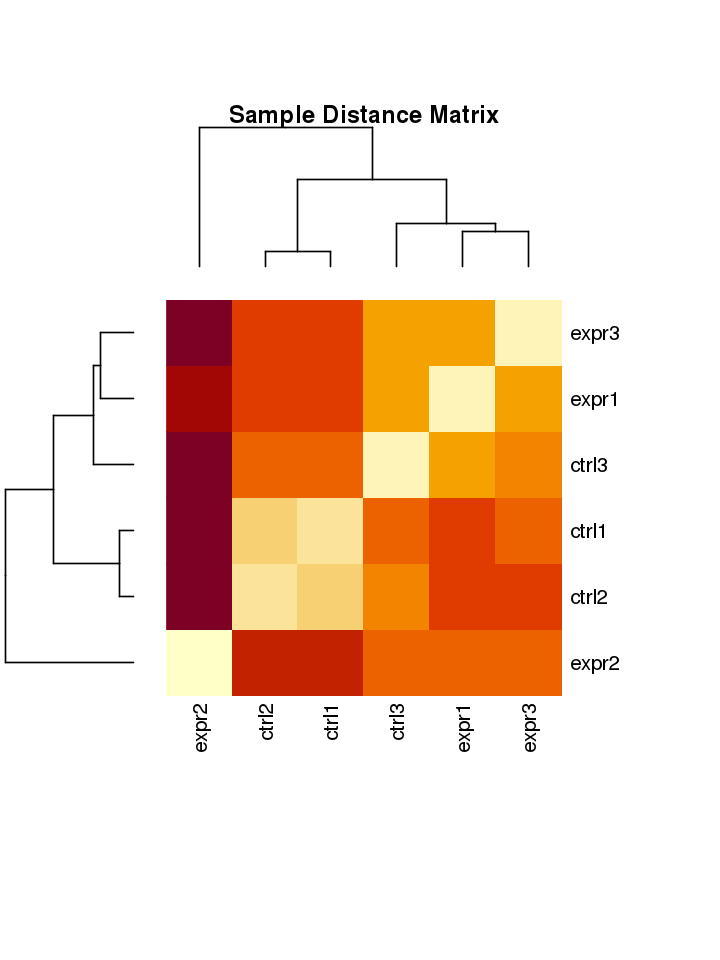

In [23]:
library(RColorBrewer)
mycols <- brewer.pal(8, "Dark2")[1:length(unique(coldata$condition))]

# Sample distance heatmap
sampleDists <- as.matrix(dist(t(assay(rld))))
heatmap(as.matrix(sampleDists),
          ColSideColors=mycols[coldata$condition], RowSideColors=mycols[coldata$condition],
          margin=c(10, 10), main="Sample Distance Matrix")

And next by PCA, using two slightly different visualizations, one supplied by DESeq and one by Stephen Turner:

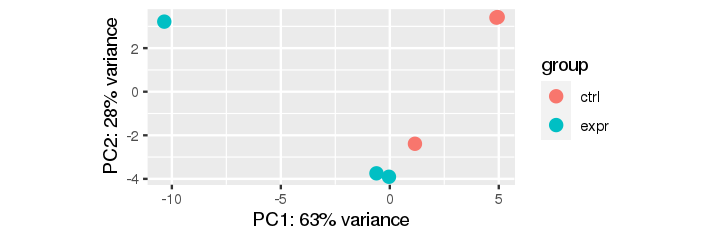

In [24]:
options(repr.plot.height=2, repr.plot.width=6)
DESeq2::plotPCA(rld, intgroup="condition")

Loading required package: genefilter


Attaching package: ‘genefilter’


The following objects are masked from ‘package:MatrixGenerics’:

    rowSds, rowVars


The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars




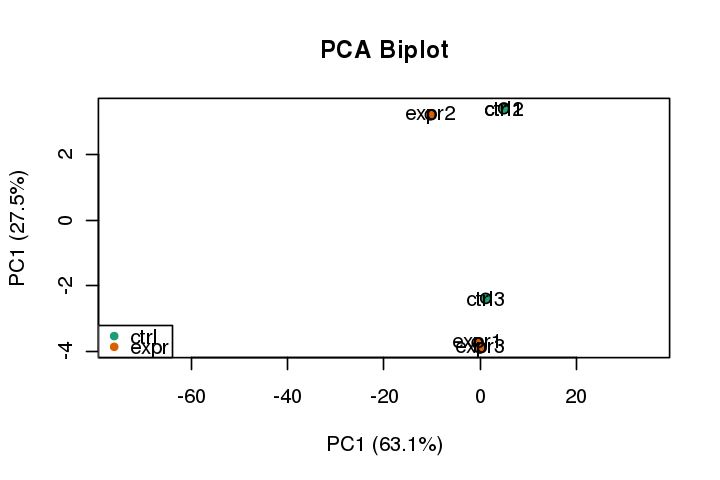

In [25]:
# Nicer PCA plot from Stephen Turner:
st_rld_pca <- function (rld, intgroup = "condition", ntop = 500, colors=NULL, legendpos="bottomleft", main="PCA Biplot", textcx=1, ...) {
  require(genefilter)
  require(RColorBrewer)
  rv = rowVars(assay(rld))
  select = order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
  pca = prcomp(t(assay(rld)[select, ]))
  fac = factor(apply(as.data.frame(colData(rld)[, intgroup, drop = FALSE]), 1, paste, collapse = " : "))
  if (is.null(colors)) {
    if (nlevels(fac) >= 3) {
      colors = brewer.pal(nlevels(fac), "Paired")
    }   else {
      colors = c("black", "red")
    }
  }
  pc1var <- round(summary(pca)$importance[2,1]*100, digits=1)
  pc2var <- round(summary(pca)$importance[2,2]*100, digits=1)
  pc1lab <- paste0("PC1 (",as.character(pc1var),"%)")
  pc2lab <- paste0("PC1 (",as.character(pc2var),"%)")
  plot(PC2~PC1, data=as.data.frame(pca$x), bg=colors[fac], pch=21, xlab=pc1lab, ylab=pc2lab, main=main, ...)
  with(as.data.frame(pca$x), text(PC1, PC2, labels=rownames(as.data.frame(pca$x)), cex=textcx))
  legend(legendpos, legend=levels(fac), col=colors, pch=20)
}
options(repr.plot.height=4, repr.plot.width=6)
st_rld_pca(rld, colors=mycols, intgroup="condition", xlim=c(-75, 35))

The case/control samples seem very clearly distinguished in the first principal component.  

## Differential Expression Analysis

Now we perform the differential expression analysis using DESeq2's built in methods, and then order the results by adjusted p-value:

In [26]:
# Get differential expression results
res <- results(dds)
## Order by adjusted p-value
res <- res[order(res$padj), ]
res <- res[complete.cases(res),]
res$pvalue <- ifelse(res$pvalue < 1.e-250, 1.e-250, res$pvalue)

summary(res)


out of 44 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 10, 23%
LFC < 0 (down)     : 10, 23%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 10)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [27]:
resdata <- merge(as.data.frame(res), as.data.frame(counts(dds, normalized=TRUE)), by="row.names", sort=FALSE)
names(resdata)[1] <- "Gene"
resdata$Gene <- as.character(resdata$Gene)
head(resdata)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ctrl1,ctrl2,ctrl3,expr1,expr2,expr3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Fgf21,46956.992,2.0809771,0.2389738,8.707973,3.093570e-18,1.361171e-16,10811.699,18803.294,24246.192,73000.728,74224.9243,80655.1160
2,AK208554,19531.733,2.3708652,0.2816304,8.418356,3.818053e-17,8.399716e-16,8696.221,5456.828,4832.346,31122.125,45852.1664,21230.7114
3,Adcy9,4647.888,-1.8151075,0.2795283,-6.493466,8.388391e-11,1.230297e-09,8823.032,6847.497,6046.273,2209.678,1346.0282,2614.8177
4,Crebbp,2478.215,-1.7736576,0.2987729,-5.936474,2.912179e-09,3.203397e-08,4283.025,3665.136,3556.420,1558.858,822.7834,983.0699
5,0610005C13Rik,373174.976,0.7523646,0.1291753,5.824371,5.732813e-09,5.044875e-08,261917.069,282636.313,289495.979,492888.608,503021.4826,409090.4014
6,Pam16,89091.858,0.7403250,0.1787055,4.142709,3.432280e-05,2.157433e-04,62392.760,78077.128,59694.478,103095.179,137651.2899,93640.3156


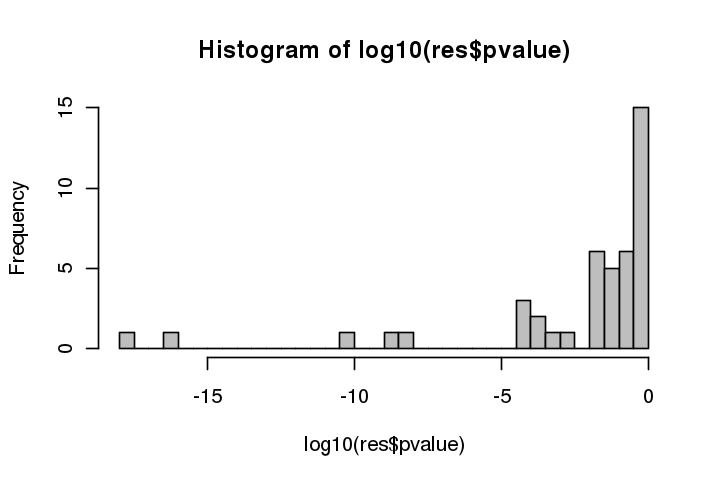

In [28]:
hist(log10(res$pvalue), breaks=50, col="grey")

As we can see, there's a substantial number of genes with extremely small p-values.

### MA plots

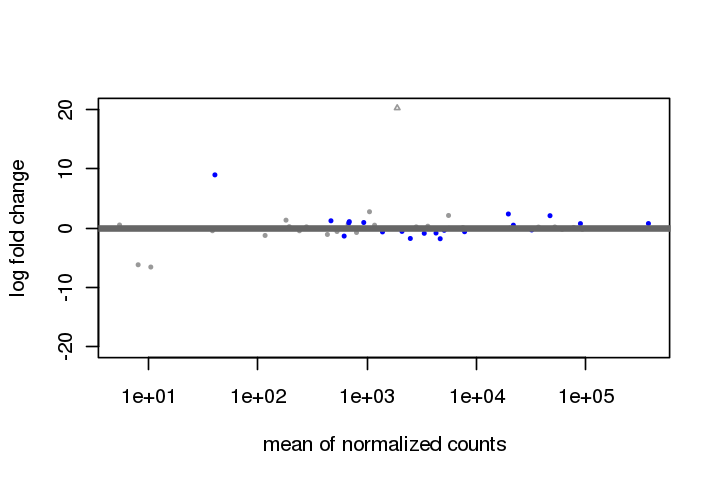

In [29]:
DESeq2::plotMA(dds)

In [30]:
# "Nicer" MA plot from Stephen Turner:
st_maplot <- function (res, thresh=0.05, labelsig=TRUE, topsig=10, textcx=1, ...) {
  with(res, plot(baseMean, log2FoldChange, pch=20, cex=.5, log="x", ...))
  with(subset(res, padj<thresh), points(baseMean, log2FoldChange, col="red", pch=20, cex=1.5))
  if (labelsig) {
    with(res[1:topsig,], text(baseMean, log2FoldChange, labels=Gene, cex=textcx, col="blue"))
    with(res[1:topsig,], points(baseMean, log2FoldChange, col="blue", pch=20, cex=1.75))
  }
}

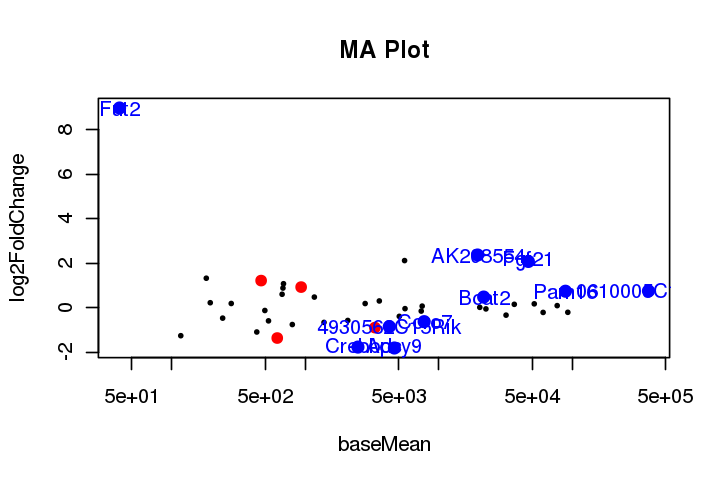

In [31]:
st_maplot(resdata, main="MA Plot")

In [32]:
# "Nicer" MA plot from Stephen Turner:
st_maplot <- function (res, thresh=0.05, labelsig=TRUE, topsig=10, textcx=1, ...) {
  with(res, plot(baseMean, log2FoldChange, pch=20, cex=.5, log="x", ...))
  with(subset(res, padj<thresh), points(baseMean, log2FoldChange, col="red", pch=20, cex=1.5))
  if (labelsig) {
    with(res[1:topsig,], text(baseMean, log2FoldChange, labels=Gene, cex=textcx, col="blue"))
    with(res[1:topsig,], points(baseMean, log2FoldChange, col="blue", pch=20, cex=1.75))
  }
}

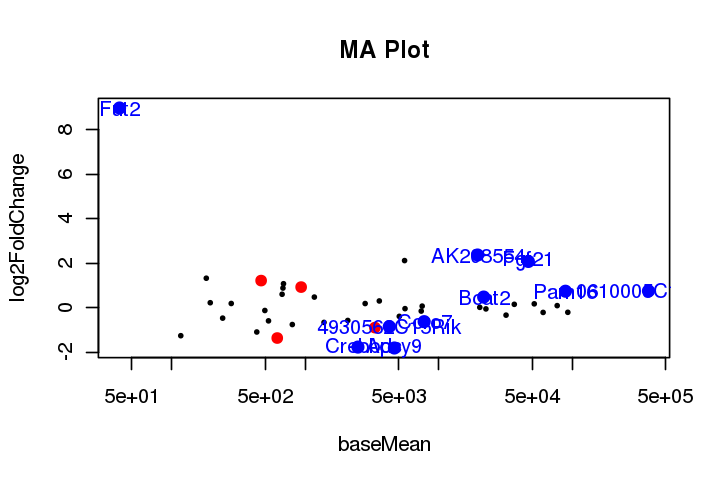

In [33]:
st_maplot(resdata, main="MA Plot")

## Volcano Plot

In [34]:
## Volcano plot with "significant" genes labeled
volcanoplot <- function (res, lfcthresh=2, sigthresh=0.0005, topsig=10, main="Volcano Plot", legendpos="bottomright", labelsig=TRUE, textcx=1, ...) {
  with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main=main, ...))
  with(subset(res, padj<sigthresh ), points(log2FoldChange, -log10(pvalue), pch=20, col="red", ...))
  with(subset(res, abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="orange", ...))
  with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="green", ...))
  if (labelsig) {
    with(subset(res, -log10(pvalue) != Inf), text(log2FoldChange[1:topsig], -log10(pvalue[1:topsig]), labels=Gene, cex=textcx, col="blue"))
    with(subset(res, -log10(pvalue) != Inf), points(log2FoldChange[1:topsig], -log10(pvalue[1:topsig]), col="blue", pch=20, ...))
  }
  legend(legendpos, xjust=1, yjust=1, legend=c(paste("FDR<",sigthresh,sep=""), paste("|LogFC|>",lfcthresh,sep=""), "both", "most significant"), pch=20, col=c("red","orange","green","blue"))
}

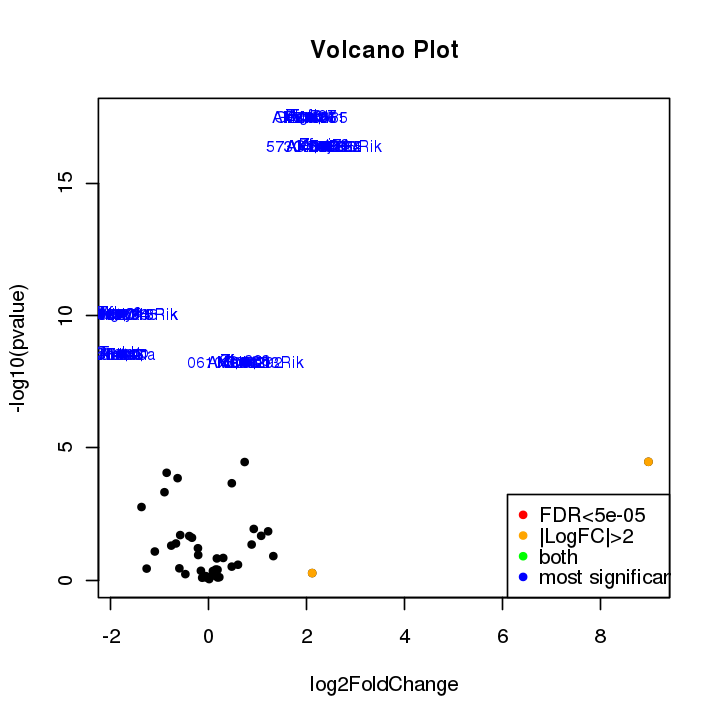

In [35]:
options(repr.plot.height=6, repr.plot.width=6)
volcanoplot(resdata, lfcthresh=2, sigthresh=0.00005, textcx=.8, topsig=5)

# for functional annotations, GO analysis, you could go to 
#Webgestalt, or use package such as http://www.webgestalt.org/
#clusterProfiler https://yulab-smu.top/clusterProfiler-book/ 
#multipenrichGem.https://jmw86069.github.io/multienrichjam/ https://jmw86069.github.io/multienrichjam/articles/importIPA.html
#IPA (commercial, available to NIH) 